# A/B Test Analysis with Country Segmentation

## Overview
This notebook performs an A/B test analysis on conversion data, segmented by country. The analysis includes:
- Cleaning and merging datasets
- Exploring data distribution by country and group
- Calculating general conversion rates
- Computing conversion rates by country and group
- Performing statistical tests (z-test) to determine if differences in conversion rates are significant

## Data Description
- `ab_data.csv`: Contains user conversion data, including user ID, timestamp, group (control or treatment), landing page, and conversion status.
- `countries.csv`: Contains mapping of user IDs to their respective countries.


In [16]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats


ab_url = 'ab_data.csv'
countries_url = 'countries.csv'

df_ab = pd.read_csv(ab_url)
df_countries = pd.read_csv(countries_url)


## Data Exploration and Cleaning
- Check for null values, data types, and duplicate entries in the datasets.
- Clean the data by removing duplicate user IDs to ensure each user is counted only once.


In [17]:
def info_df(df: pd.DataFrame, subset_starter=1):
    data = {
        'Data Feature': df.columns,
        'Data Type': df.dtypes,
        'Null Values': df.isnull().sum(),
        'Count Unique': df.nunique(),
        'Duplicated Values': df.duplicated(subset=df.columns.tolist()[subset_starter:]).sum(),    
        'Unique Sample': [df[col].sample(5).to_list() for col in df.columns]
    }
    
    info_data = pd.DataFrame(data)
    return info_data

info_ab = info_df(df_ab, subset_starter=0)
info_c = info_df(df_countries, subset_starter=0)

d_in_df_ab = df_ab.duplicated(subset='user_id').sum()
d_in_df_c = df_countries.duplicated(subset='user_id').sum()

df_ab_clean = df_ab.drop_duplicates(subset='user_id')
df_countries_clean = df_countries.drop_duplicates(subset='user_id')

print(f'Duplicated user ids:\n{"-"*20}\nab_data: {d_in_df_ab}\ncountries_data: {d_in_df_c}')
print(f'\nShape:\n{"-"*20}\nab_data: {df_ab.shape}\nab_data_clean: {df_ab_clean.shape}')
print(f'countries_data: {df_countries.shape}\ncountries_data_clean: {df_countries_clean.shape}')

info_ab

Duplicated user ids:
--------------------
ab_data: 3895
countries_data: 1

Shape:
--------------------
ab_data: (294480, 5)
ab_data_clean: (290585, 5)
countries_data: (290586, 2)
countries_data_clean: (290585, 2)


,Data Feature,Data Type,Null Values,Count Unique,Duplicated Values,Unique Sample
user_id,user_id,int64,0,290585,0,"[907105, 811939, 733840, 792024, 929355]"
timestamp,timestamp,object,0,35993,0,"[39:31.0, 12:22.2, 16:19.3, 37:36.5, 22:58.8]"
group,group,object,0,2,0,"[control, control, treatment, control, treatment]"
landing_page,landing_page,object,0,2,0,"[new_page, old_page, old_page, new_page, new_p..."
converted,converted,int64,0,2,0,"[1, 1, 0, 0, 0]"


## Data Merging
- Merge cleaned datasets on `user_id` to combine conversion data with country information.


In [18]:
df = df_ab_clean.merge(df_countries_clean, on='user_id')

print(df.shape)
df.head()


(290585, 6)


,user_id,timestamp,group,landing_page,converted,country
0,851104,11:48.6,control,old_page,0,US
1,804228,01:45.2,control,old_page,0,US
2,661590,55:06.2,treatment,new_page,0,US
3,853541,28:03.1,treatment,new_page,0,US
4,864975,52:26.2,control,old_page,1,US


## Data Exploration by Country and Group
- Analyze the distribution of users by country and the number of users in each group (control and treatment).


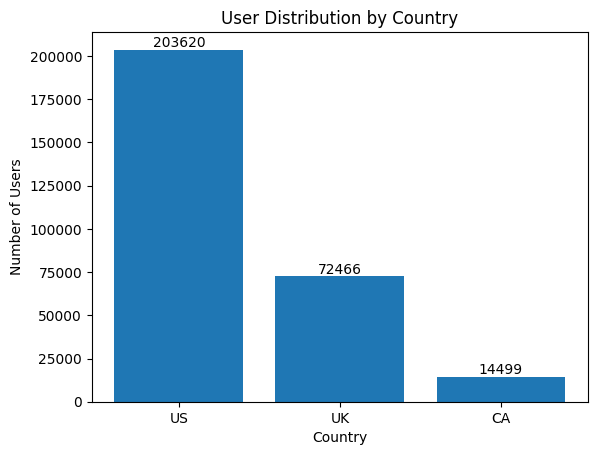

grouped_df: group
control      145232
treatment    145353
Name: user_id, dtype: int64

121 more cases to the treatment group


In [19]:
country_values = df['country'].value_counts()

x = country_values.index
y = country_values.values

plt.bar(x=x, height=y)
for i, height in enumerate(y):
    plt.text(i, height + 5, str(height), ha='center', va='bottom')
plt.xlabel('Country')
plt.ylabel('Number of Users')
plt.title('User Distribution by Country')
plt.show()

grouped_df = df.groupby(by='group')['user_id'].count()

print(f'grouped_df: {grouped_df}\n\n{abs(grouped_df[0]-grouped_df[1])} more cases to the treatment group')


## General Conversion Rate Analysis
- Calculate and visualize conversion rates for control and treatment groups.


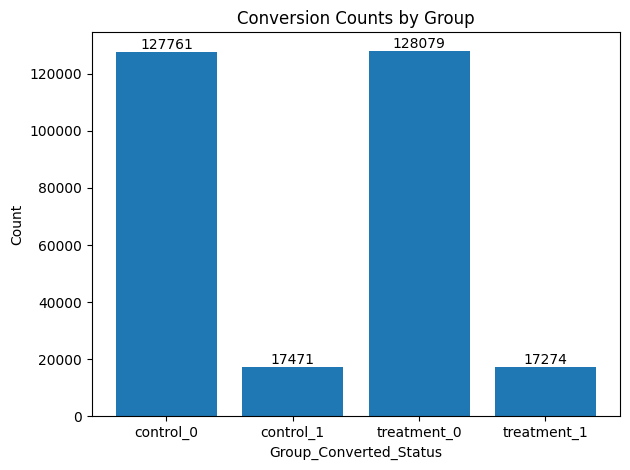

control converted mean: 0.1203
treatment converted mean: 0.1188


In [20]:
control_0 = len(df[(df['group'] == 'control') & (df['converted'] == 0)])
control_1 = len(df[(df['group'] == 'control') & (df['converted'] == 1)])
treatment_0 = len(df[(df['group'] == 'treatment') & (df['converted'] == 0)])
treatment_1 = len(df[(df['group'] == 'treatment') & (df['converted'] == 1)])

x = ['control_0', 'control_1', 'treatment_0', 'treatment_1']
y = [control_0, control_1, treatment_0, treatment_1]

plt.bar(x=x, height=y)
for i, height in enumerate(y):
    plt.text(i, height + 5, str(height), ha='center', va='bottom')
plt.xlabel('Group_Converted_Status')
plt.ylabel('Count')
plt.title('Conversion Counts by Group')
plt.tight_layout()
plt.show()

control_mean = df[df['group'] == 'control']['converted'].mean()
treatment_mean = df[df['group'] == 'treatment']['converted'].mean()

print(f'control converted mean: {control_mean:.4f}\ntreatment converted mean: {treatment_mean:.4f}')


## Conversion Rate by Country and Group
- Calculate conversion rates by country and group (control and treatment).
- Visualize conversion rates.


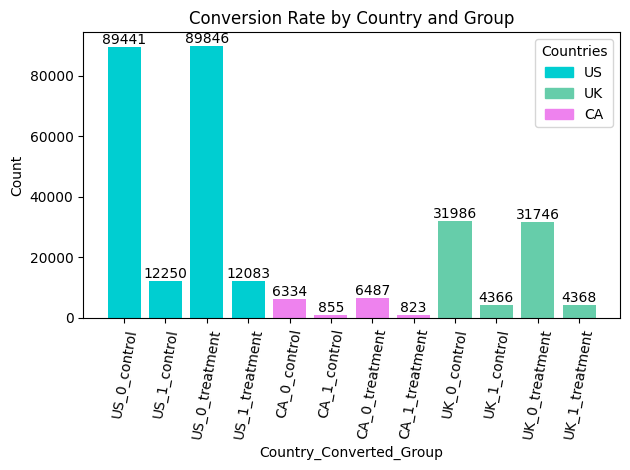

In [21]:
country_group_conv = {}

for country in df['country'].unique():
    for group in ['control', 'treatment']:
        
        for converted in range(2):
            key = f'{country}_{converted}_{group}'
            count = len(df[(df['group'] == group) & (df['country'] == country) & (df['converted'] == converted)])
            country_group_conv[key] = count

color_map = {
    'US': 'darkturquoise',
    'UK': 'mediumaquamarine',
    'CA': 'violet'
}

x = [i for i in country_group_conv.keys()]
y = [i for i in country_group_conv.values()]
colors = [color_map.get(key.split('_')[0]) for key in x]

plt.bar(x=x, height=y, color=colors)
for i, height in enumerate(y):
    plt.text(i, height + 5, str(height), ha='center', va='bottom')

plt.xlabel('Country_Converted_Group')
plt.ylabel('Count')
plt.title('Conversion Rate by Country and Group')
plt.legend(handles=[plt.Rectangle((0,0),1,1, color=color) for color in color_map.values()],
           labels=color_map.keys(), title="Countries")
plt.xticks(rotation=80)    
plt.tight_layout()
plt.show()


## Hypothesis

In this analysis, we aim to determine whether there is a significant difference in conversion rates between users who were exposed to the old page (control group) and those who were exposed to the new page (treatment group).

### Null Hypothesis (H₀)
The null hypothesis states that there is no difference in the conversion rates between the control and treatment groups. Mathematically, this can be represented as:
\[
H₀: p_{control} = p_{treatment}
\]
where \( p_{control} \) is the conversion rate of the control group and \( p_{treatment} \) is the conversion rate of the treatment group.

### Alternative Hypothesis (H₁)
The alternative hypothesis states that there is a difference in the conversion rates between the control and treatment groups. This can be represented as:
\[
H₁: p_{control} \neq p_{treatment}
\]
### Testing Approach

To test these hypotheses, we conducted a z-test to compare the conversion rates of the control and treatment groups. A z-test is appropriate here as it helps determine whether the observed differences in conversion rates are statistically significant or if they could have occurred by random chance.

The significance level (\(\alpha\)) was set at 0.05, meaning that if the p-value from the z-test is less than 0.05, we would reject the null hypothesis in favor of the alternative hypothesis.


## Statistical Analysis: Z-Test and P-Value
- Perform z-test to determine if the difference in conversion rates between control and treatment groups is statistically significant.
- Calculate z-scores and p-values for each country.


In [22]:
conversion_dict = {'means': [],
                   'std': [],
                   'sample_size': [],
                   'se': [],
                   'country': [],
                   }
columns = []

for country in country_values.index:
    for group in ['control', 'treatment']:
        filtered_data = df[(df['group'] == group) & (df['country'] == country)]['converted']
        
        mean_conv = filtered_data.mean()
        std_conv = filtered_data.std()
        sample_size = len(filtered_data)
        se_conv = std_conv / np.sqrt(sample_size)
        
        conversion_dict['se'].append(se_conv)   
        conversion_dict['means'].append(mean_conv)
        conversion_dict['std'].append(std_conv)
        conversion_dict['sample_size'].append(sample_size)
        conversion_dict['country'].append(country)
        
        columns.append(f'{country}_{group}')

            

conversion_dict['z_score'] = []
conversion_dict['p_value'] = []

for i in range(0, len(conversion_dict['country']), 2):
    mean_control = conversion_dict['means'][i]
    mean_treatment = conversion_dict['means'][i+1]
    se_control = conversion_dict['se'][i]
    se_treatment = conversion_dict['se'][i+1]
    n_control = conversion_dict['sample_size'][i]
    n_treatment = conversion_dict['sample_size'][i+1]
    
    difference_in_means = mean_treatment - mean_control

    combined_se = np.sqrt(se_control**2 + se_treatment**2)

    z_score = difference_in_means / combined_se

    p_value = stats.norm.sf(abs(z_score)) * 2  

    conversion_dict['z_score'].append(z_score)
    conversion_dict['p_value'].append(p_value)

    conversion_dict['z_score'].append(z_score)
    conversion_dict['p_value'].append(p_value)

pd.DataFrame(conversion_dict, index=columns)


,means,std,sample_size,se,country,z_score,p_value
US_control,0.120463,0.325504,101691,0.001021,US,-1.335215,0.181806
US_treatment,0.118543,0.323252,101929,0.001012,US,-1.335215,0.181806
UK_control,0.120103,0.325087,36352,0.001705,UK,0.350107,0.726258
UK_treatment,0.120950,0.326074,36114,0.001716,UK,0.350107,0.726258
CA_control,0.118932,0.323731,7189,0.003818,CA,-1.194054,0.232457
CA_treatment,0.112585,0.316107,7310,0.003697,CA,-1.194054,0.232457


## Conclusion


 **Statistical Significance**:
   - The z-test results show that none of the differences in conversion rates between the control and treatment groups were statistically significant at the 0.05 level. This means that any observed differences in conversion rates are likely due to random chance rather than a true effect of the new page.

### Conclusion:
Based on the analysis, there is no significant evidence to suggest that the new page (treatment) performs better or worse than the old page (control) across all users and individual countries. Therefore, we fail to reject the null hypothesis, indicating that there is no statistically significant difference in conversion rates between the control and treatment groups.

